In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.nz_model as nz
from lbg_forecast.nz_model import NzModel

In [2]:
def gather_redshifts(nfiles, path):
    i = 0
    nz_data = []
    while(i < nfiles):
        nzs = np.load(path+"redshifts/emulated_redshifts_"+str(i)+".npy", allow_pickle=True)
        nsamples = nzs.shape[0]
        j = 0
        while(j < nsamples):
            nz_data.append(nzs[j, :])
            j+=1
        i+=1

    return np.asarray(nz_data)

In [3]:
#convert histogram to function (old code - slow)
def pdf(z, hist):
    
    bin_l = len(hist[1])
    pdf_l = len(hist[0]) #(bin_l - 1)
    
    bin_list = hist[1]
    pdf_list = hist[0]
    bin_no = 0
    
    for binn in bin_list:
        if(bin_no >= pdf_l):
            break
        if(binn > z):
            break
        bin_no+=1
    
    bin_no = bin_no-1
    if(bin_no > 0 or bin_no < bin_l):
        return pdf_list[bin_no]
    else:
        return 0.0
    
def get_zgrid_for_bins(hist_bins, factor):

    bins_start = hist_bins[0]
    bins_end = hist_bins[-1]

    z_list = np.linspace(bins_start, bins_end, len(hist_bins)*factor)

    return z_list

#over sample by factor of 10
def convert_hist_to_pdf(hist, factor):
        
        z_list = get_zgrid_for_bins(hist[1], factor)
        pdf_list = []
        for z in z_list:
            pdf_list.append(pdf(z, hist))

        #plt.plot(z_list, pdf_list)
        
        return (z_list, pdf_list)

#very slow!!!
def process_redshifts(nzs, bin_size, factor, path):
     
    dz = bin_size
    minz = 0.0
    maxz = 7.0
    bins = np.arange(minz, maxz+dz, dz)

    dropout = 0
    sample = 0
    nsamples = nzs.shape[0]
    newnzs = np.empty(3, dtype=object)
    while(dropout < 3):
        dropouts = []
        sample = 0
        while(sample < nsamples):
            nzhist = np.histogram(nzs[sample, dropout], density=True, bins=bins)
            dropouts.append(convert_hist_to_pdf(nzhist, factor)[1])
            sample+=1
        dropouts = np.asarray(dropouts)
        newnzs[dropout] = dropouts
        dropout+=1
    
    z_grid = get_zgrid_for_bins(bins, factor)
    np.save(path+"redshifts/nzus.npy", newnzs[0])
    np.save(path+"redshifts/nzgs.npy", newnzs[1])
    np.save(path+"redshifts/nzrs.npy", newnzs[2])
    np.save(path+"redshifts/z_grid.npy", z_grid)

    return z_grid, newnzs
               


In [4]:
nzs = gather_redshifts(1, path="./")
total_nzs = len(nzs)
print("total nzs:", total_nzs)

total nzs: 64


In [5]:
z_grid, nz_pdfs = process_redshifts(nzs, 0.2, 50, path="./")

In [6]:
nzmodel = NzModel(path="./")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


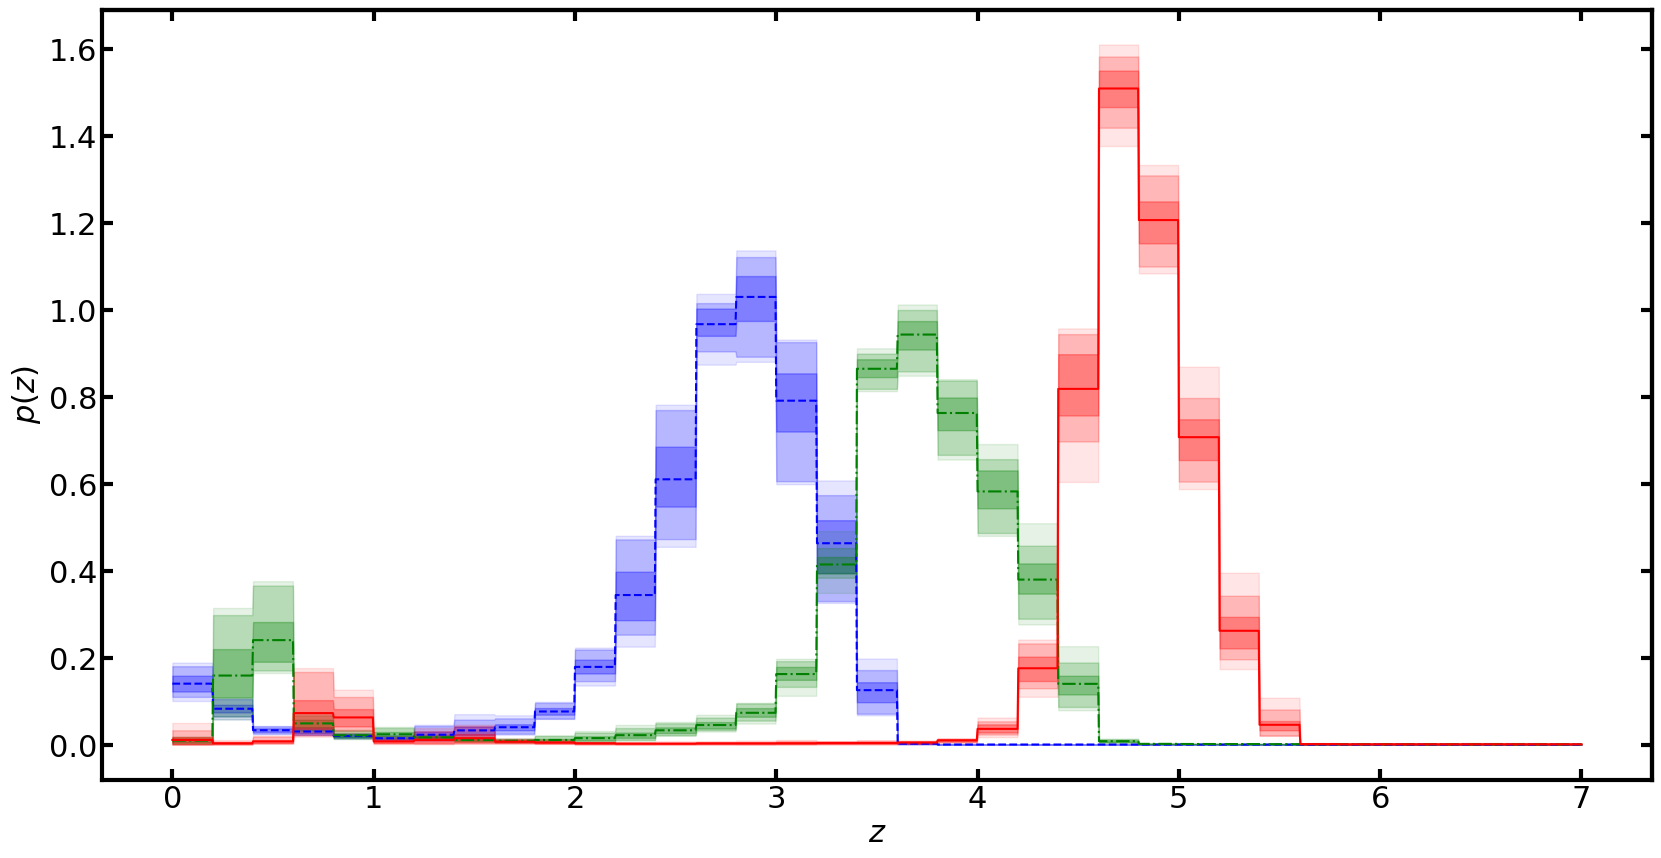

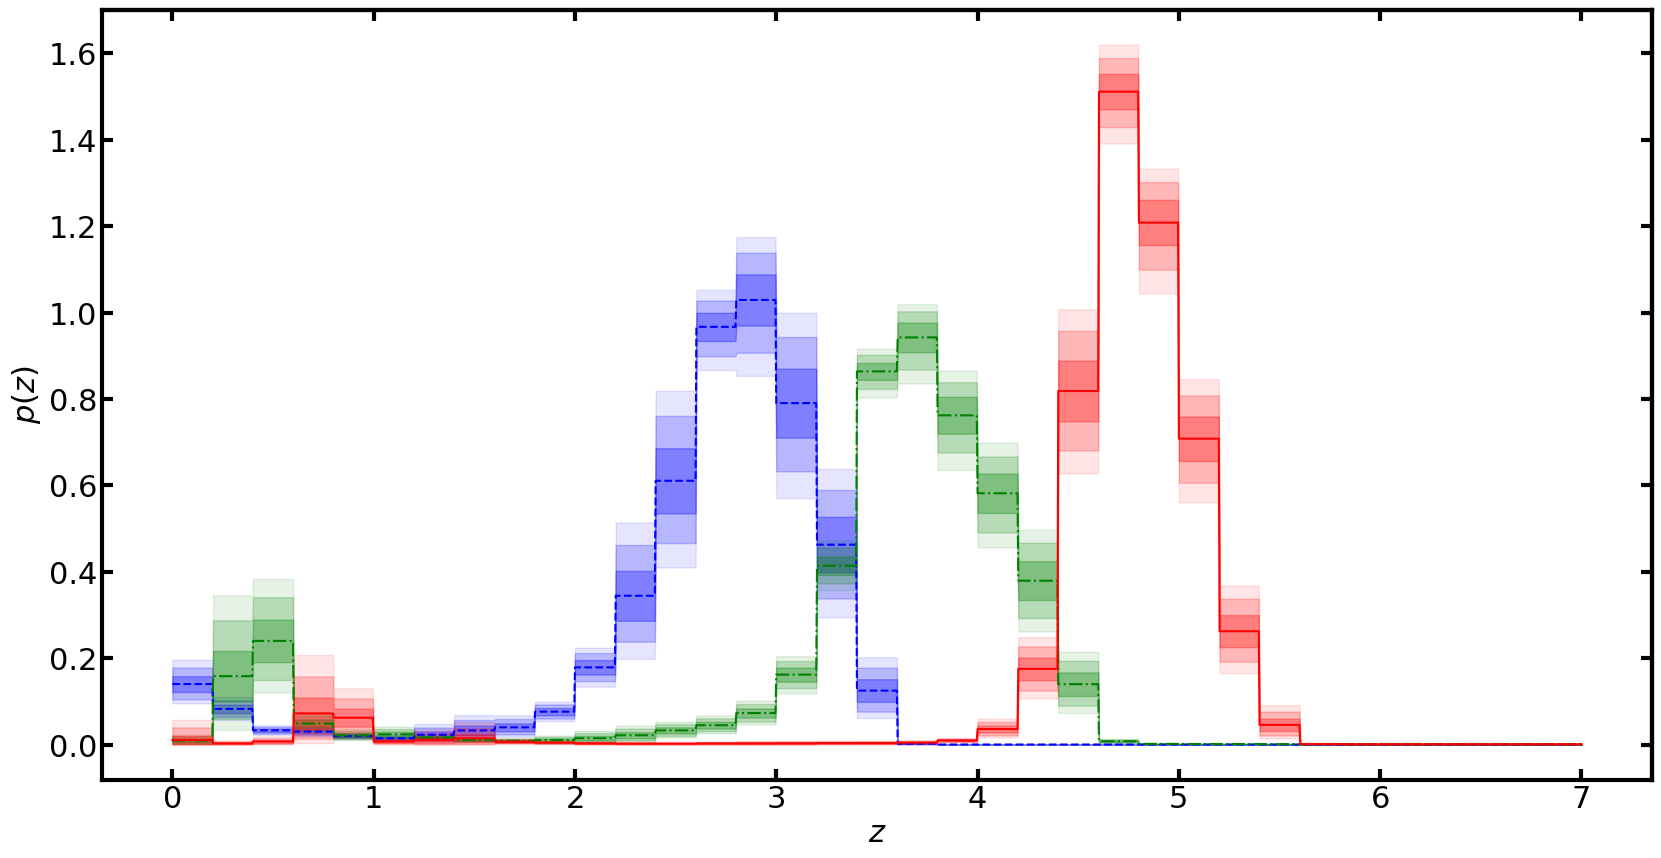

In [7]:
nzmodel.plot_all_data()
nzmodel.plot_all_pca(12, 10000)

(1800,)
15.412579762034815
13.387253315112709
12.321660023861883
11.783214269495906
10.2448355161648
9.878384340511362
7.966080787748349
7.37421462390924
7.37230357047598
7.005154875652902
6.4113412047143745
6.668494925846073
6.184778582255271
5.898270678251819


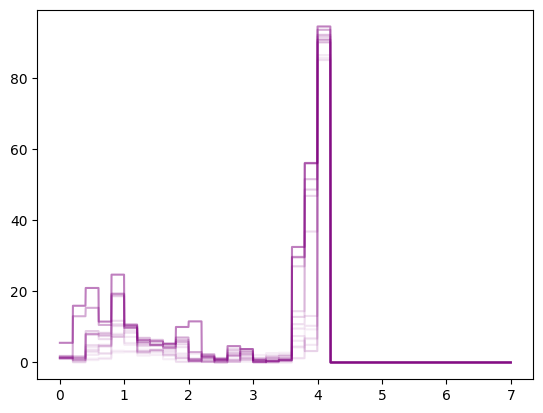

In [8]:
print(z_grid.shape)

running_err = []
pcas = np.arange(2, 16, 1)
for npca in pcas:

    binvals = nzmodel.u_data()
    binvals_pca = nzmodel.u_pca(npca, 10000)
    z_grid = nzmodel._z_space

    err = []
    for i in range(z_grid.shape[0]):
        binval = binvals[:, i]
        binval_pca = binvals_pca[:, i]
        if(np.std(binval)!=0):
            err.append(((abs(np.std(binval_pca) - np.std(binval)))/(np.std(binval)))*100)
        else:
            err.append(0)


    plt.plot(z_grid, err, color='purple', alpha=(1/npca))

    err=np.array(err)
    err = np.mean(err[np.where(err>0)[0]])
    running_err.append(err)
    print(err)

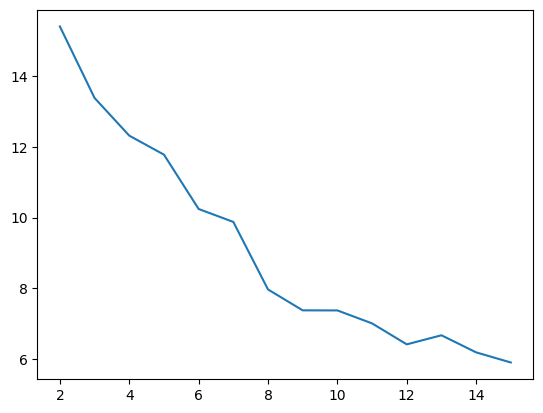

In [9]:
plt.plot(pcas, running_err)

0.4776837702251912


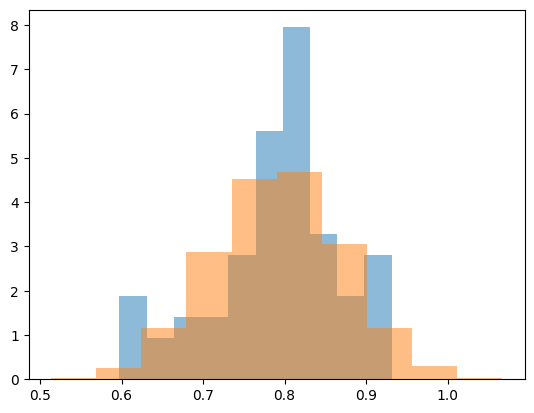

In [10]:
npca=12

binvals = nzmodel.u_data()
binvals_pca = nzmodel.u_pca(npca, 10000)
z_grid = nzmodel._z_space

error = []
for i in range(z_grid.shape[0]):
    binval = binvals[:, i]
    binval_pca = binvals_pca[:, i]
    if(np.std(binval)!=0):
        error.append(((abs(np.std(binval_pca) - np.std(binval)))/(np.std(binval)))*100)
    else:
        error.append(0)

    z=3.0
    if(i == int(z*(1800/7))):
        plt.hist(binval, density = True, alpha=0.5)
        plt.hist(binval_pca, density = True, alpha=0.5)
        print(error[i])

(1800,)
25.75748975434281
24.50663441089513
17.928659945618126
17.155910205752562
15.504897474280487
13.993450349094271
12.361528555455331
12.698317883264991
10.80066642087307
9.517728940265052
8.51904607386891
8.392715599382853
6.829761767816721
6.492028205391275


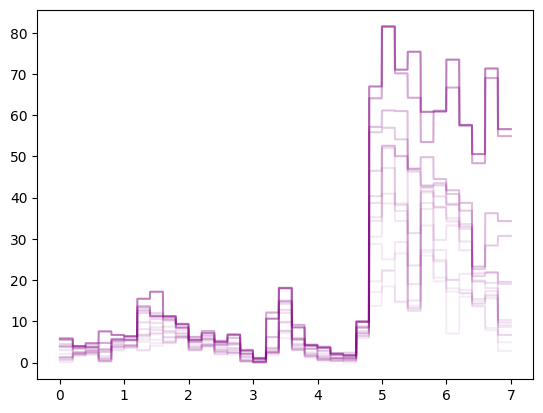

In [11]:
print(z_grid.shape)

running_err = []
pcas = np.arange(2, 16, 1)
for npca in pcas:

    binvals = nzmodel.g_data()
    binvals_pca = nzmodel.g_pca(npca, 10000)
    z_grid = nzmodel._z_space

    err = []
    for i in range(z_grid.shape[0]):
        binval = binvals[:, i]
        binval_pca = binvals_pca[:, i]
        if(np.std(binval)!=0):
            err.append(((abs(np.std(binval_pca) - np.std(binval)))/(np.std(binval)))*100)
        else:
            err.append(0)


    plt.plot(z_grid, err, color='purple', alpha=(1/npca))

    err=np.array(err)
    err = np.mean(err[np.where(err>0)[0]])
    running_err.append(err)
    print(err)

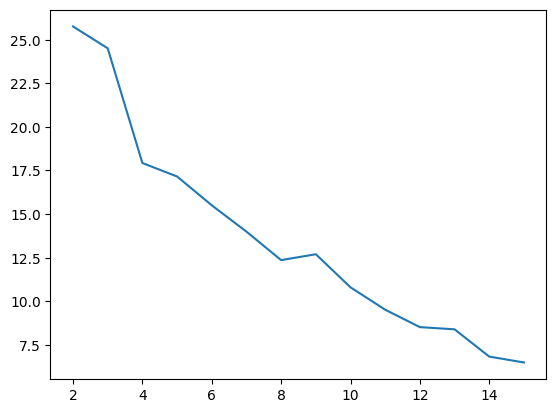

In [12]:
plt.plot(pcas, running_err)

1.1747509263293683


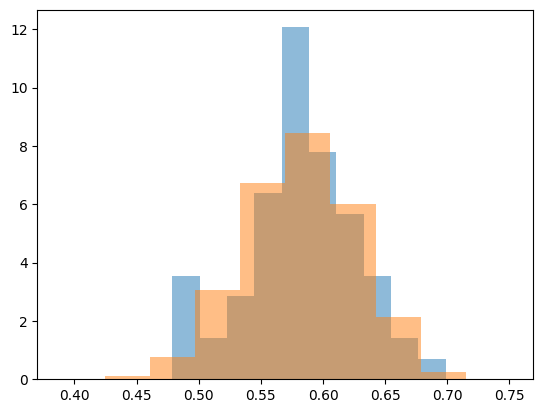

In [13]:
npca=12

binvals = nzmodel.g_data()
binvals_pca = nzmodel.g_pca(npca, 10000)
z_grid = nzmodel._z_space

error = []
for i in range(z_grid.shape[0]):
    binval = binvals[:, i]
    binval_pca = binvals_pca[:, i]
    if(np.std(binval)!=0):
        error.append(((abs(np.std(binval_pca) - np.std(binval)))/(np.std(binval)))*100)
    else:
        error.append(0)

    z=4.0
    if(i == int(z*(1800/7))):
        plt.hist(binval, density = True, alpha=0.5)
        plt.hist(binval_pca, density = True, alpha=0.5)
        print(error[i])

(1800,)
38.93913250818899
33.845130406318845
28.85518627217713
26.055174369219273
21.419223971519123
19.761005813610755
16.286292571214478
14.223068092357563
12.655464540792616
10.67625561168776
10.086345872244232
8.591598976357783
8.528184703557121
7.966932967854083


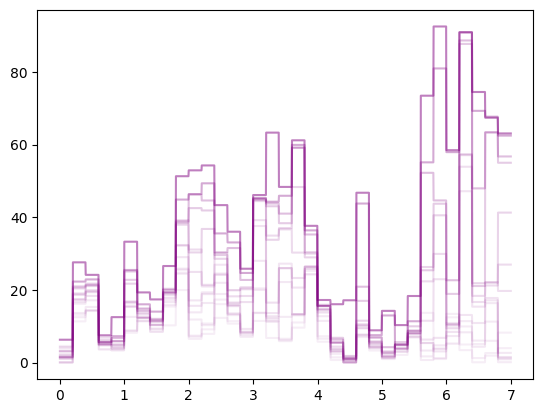

In [14]:
print(z_grid.shape)

running_err = []
pcas = np.arange(2, 16, 1)
for npca in pcas:

    binvals = nzmodel.r_data()
    binvals_pca = nzmodel.r_pca(npca, 10000)
    z_grid = nzmodel._z_space

    err = []
    for i in range(z_grid.shape[0]):
        binval = binvals[:, i]
        binval_pca = binvals_pca[:, i]
        if(np.std(binval)!=0):
            err.append(((abs(np.std(binval_pca) - np.std(binval)))/(np.std(binval)))*100)
        else:
            err.append(0)


    plt.plot(z_grid, err, color='purple', alpha=(1/npca))

    err=np.array(err)
    err = np.mean(err[np.where(err>0)[0]])
    running_err.append(err)
    print(err)

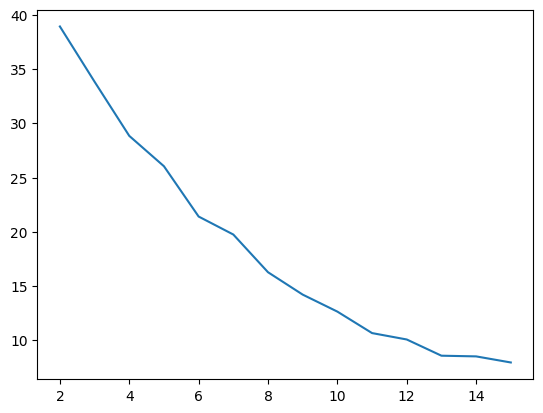

In [15]:
plt.plot(pcas, running_err)

0.9779310682907321


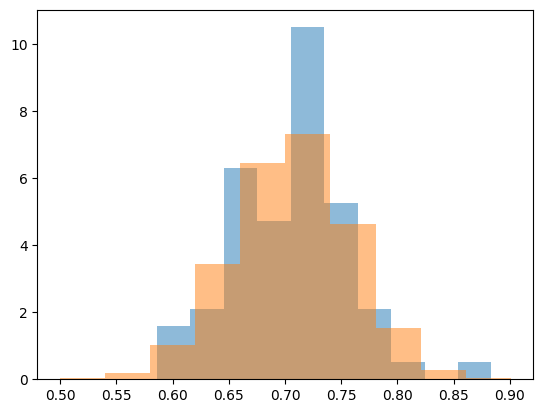

In [16]:
npca=12

binvals = nzmodel.r_data()
binvals_pca = nzmodel.r_pca(npca, 10000)
z_grid = nzmodel._z_space

error = []
for i in range(z_grid.shape[0]):
    binval = binvals[:, i]
    binval_pca = binvals_pca[:, i]
    if(np.std(binval)!=0):
        error.append(((abs(np.std(binval_pca) - np.std(binval)))/(np.std(binval)))*100)
    else:
        error.append(0)

    z=5.0
    if(i == int(z*(1800/7))):
        plt.hist(binval, density = True, alpha=0.5)
        plt.hist(binval_pca, density = True, alpha=0.5)
        print(error[i])